In [1]:
import xarray as xr
import nowpp
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
import cmclimate as cmc
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://10.0.64.17/23890/1 Dashboard: http://localhost:34833/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()
cmap_temp = cmc.cm.MPL_gist_heat_r
cmap_diff = cmc.cm.hotcolr_19lev

In [4]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futMHW = xr.open_dataarray(localDir + 'mhws_NOWFutRun.nc')
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')

In [5]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [6]:
futMHW = futMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

Index: 
* Max Severity 
* Max SSTA 
* Number of MHW Days 
* All plotted together, Changes in Mean state

In [7]:
def norm_fit(dataset, bins):
    '''
    Takes in a dataset and # of bins and returns a normal distrubition fit for the PDF of the dataset.
    '''
    mu = dataset.mean().compute()
    sigma = dataset.std().compute()
    fit = ((1 / (np.sqrt(2 * np.pi) * sigma.data)) * np.exp(-0.5 * (1 / sigma.data * (bins - mu.data))**2))
    return fit

In [8]:
letters = list(map(chr, range(97, 123))) #<-- Creates a list of lowercase letters

def add_letters(axes, x_loc = 90, y_loc = 0):
    '''
    Takes in a set of axes and plots letters in the top corner for each plot.
    x_loc & y_loc are the x,y coordinates for the textbox. 
    mult
    '''
    ax = axes.ravel()
    for i in range(len(ax)):
            ax[i].text(x_loc, y_loc, letters[i], fontsize = 16, bbox={'facecolor':'snow','edgecolor': 'black','pad': 10});

## Finding mean of the max severity per year in future and past MHWs
This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the top of the model, which seemed to give some weird results.

In [9]:
maxFutSev = futMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/core/common.py:499: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  restore_coord_dims=restore_coord_dims)


In [10]:
maxPastSev = pastMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/core/common.py:499: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  restore_coord_dims=restore_coord_dims)


In [11]:
# Replaces land masses with nan as opposed to 0 value
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)
maxFutSev = xr.where(maxFutSev == 0, np.nan, maxFutSev)

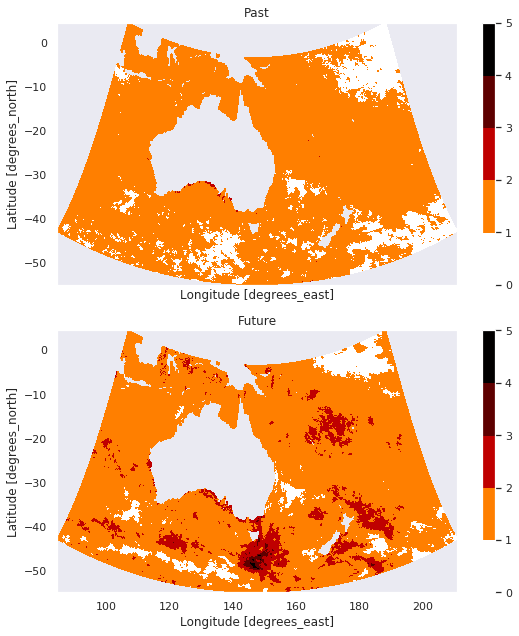

In [137]:
vmin = 0; vmax = 5;
fig, (ax1, ax2) = plt.subplots(2, 1, figsize =(8,9), sharex = True)
levels = [0,1,2,3,4,5]
maxPastSev.plot(cmap = cmap_temp, ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, levels = levels);
maxFutSev.plot(cmap = cmap_temp,ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, levels = levels);
fig.tight_layout()
ax1.set_title('Past')
ax2.set_title('Future');

### Histogram

In [33]:
# Grid file contains the x and y size for each grid box within our model
grid = xr.open_dataset('/g/data1/e14/gs9353/NOW_OUTPUTS/MESH/mesh_mask_cordex24.nc')
gridx = grid['e1t'].isel(t= 0)
gridy = grid['e2t'].isel(t= 0)
# Assuming locally flat geometry, we can calculate the area at each grid cell
area = gridx * gridy
# As we have removed some of our model data, we remove the same portion from the calculated 
area = area.isel(x = slice(5,-5), y = slice(5,-50))
# Calculates the area weights 
area_weights = area / area.max()

In [34]:
maxPastSev_weight = (maxPastSev * area_weights)
maxFutSev_weight = (maxFutSev * area_weights)

ValueError: weights should have the same shape as x

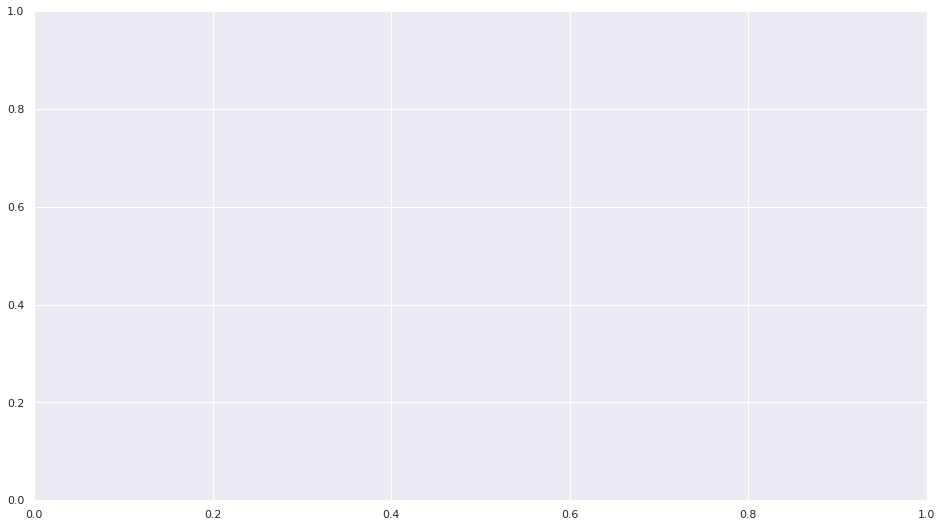

In [36]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,4,250)

# True if plotting densities, false if you want just frequency
pltDens = True

weights_dens = np.ones_like(maxPastSev_weight)/float(len(maxPastSev_weight))

maxPastSev_weight.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Hindcast Data', histtype ='stepfilled', color = 'teal')
maxFutSev_weight.plot.hist(align = 'left',  bins = bins, density = pltDens, label = 'Forecast Data', histtype ='stepfilled', color = 'firebrick', alpha = 0.8);

past_std = np.round(maxPastSev.std().data,3)
fut_std = np.round(maxFutSev.std().data,3)
std_str = ('Standard Deviation: \nHIND = {0} \nFUT   = {1}').format(past_std, fut_std)
plt.text(3.0, 1, std_str)
plt.legend()

plt.ylabel('Probability Density')
plt.xlabel('Severity')

plt.title('Probability Density Function for Average Maximum Severity per Year');
plt.xlim(0);
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/variations/aveMaxSeverityPerYearPDF_semiTrans.png')

### Significance  

In [40]:
sev_diff = maxFutSev - maxPastSev

In [41]:
maxPastSev_year = pastMHW.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))
maxFutSev_year = futMHW.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/core/common.py:499: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  restore_coord_dims=restore_coord_dims)


In [42]:
(t, sev_pValue)  = stats.ttest_rel(maxPastSev_year, maxFutSev_year)

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [43]:
sev_sig = np.where(sev_pValue > 0.05, np.nan, sev_pValue) 
# If you run the below, sev_sig stores the non-significant locations (meaning that the non contoured regions of your plot show the 
# significant results)
#sev_sig = np.where(sev_pValue < 0.05, np.nan, sev_pValue) 

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


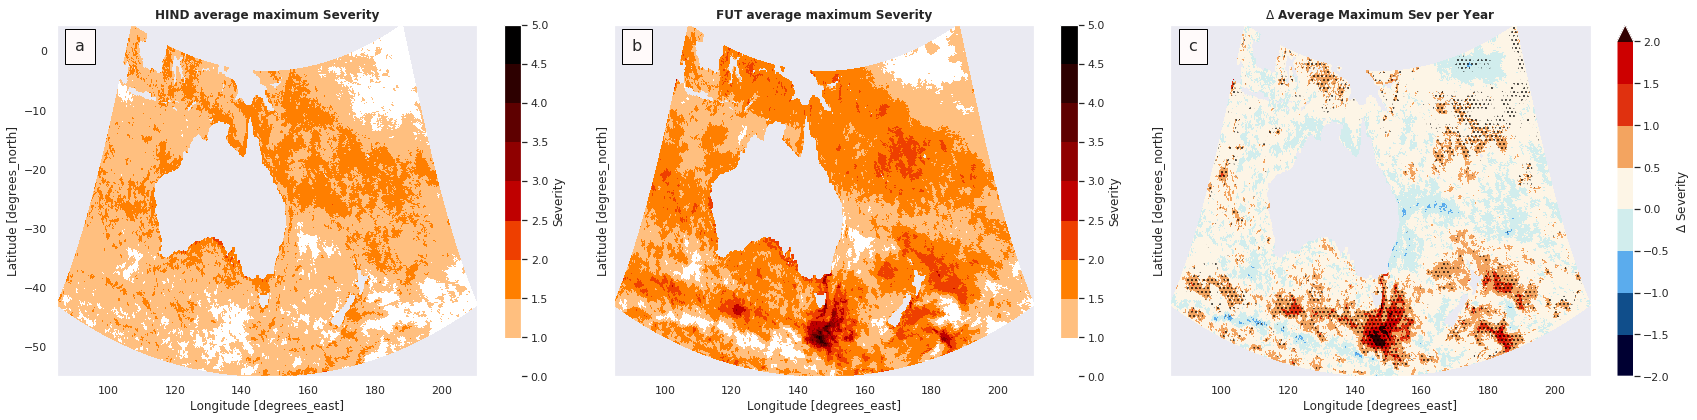

In [104]:
fig, axes = plt.subplots(1,3, sharey = True, figsize = [24, 6])
diff_max = 2
levels_diff = linspace(-diff_max, diff_max, 4*diff_max + 1)
#Past and Future plots
vmin, vmax = (0, 5)
levels = [vmin, *linspace(1, vmax, (vmax - 1) * 2 + 1)]
maxPastSev.plot(cmap = cmap_temp, ax = axes[0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, levels = levels, cbar_kwargs = {'label' : 'Severity'});
maxFutSev.plot(cmap = cmap_temp, ax = axes[1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax,  levels = levels, cbar_kwargs = {'label' : 'Severity'});
axes[0].set_title('HIND average maximum Severity', fontweight = 'bold')
axes[1].set_title('FUT average maximum Severity', fontweight = 'bold')

# Difference plots
y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
sev_diff.plot(cmap = cmap_diff, x = 'nav_lon', y = 'nav_lat', ax = axes[2], levels = levels_diff, cbar_kwargs = {'label' : '$\Delta$ Severity'}, )
axes[2].contourf(sev_diff['nav_lon'], sev_diff['nav_lat'], sev_sig, levels = [0,1], hatches=['...'], colors = 'none');
axes[2].set_title('$\Delta$ Average Maximum Sev per Year', fontweight = 'bold');

add_letters(axes)
fig.tight_layout();
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSev_all3_stip.png')

### Seasonal

In [270]:
maxPastSev_seas = pastMHW.groupby('time_counter.season').max(dim = 'time_counter').compute()
maxFutSev_seas = futMHW.groupby('time_counter.season').max(dim = 'time_counter').compute()

In [271]:
maxSev_diff_seas = maxFutSev_seas - maxPastSev_seas

seasons = {0:'Summer', 1:'Autumn', 2:'Winter', 3:'Spring'}

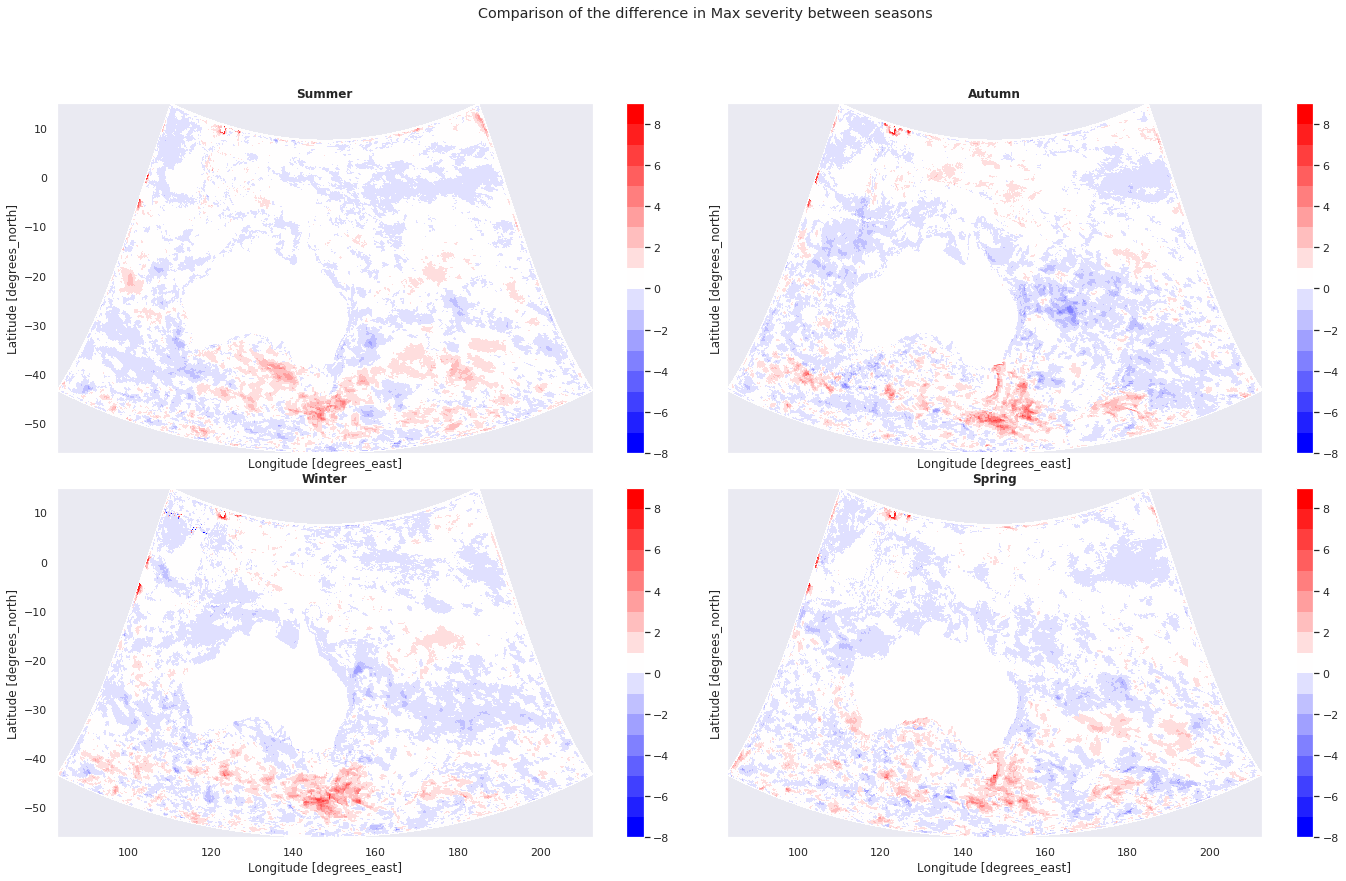

In [336]:
f, axes = plt.subplots(2,2, figsize = (24, 13.5), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Max severity between seasons')
vmin, vmax = (-8, 9)
levels = linspace(vmin,vmax, vmax - vmin + 1)
i = 0
for ax in axes.flat:
    maxSev_diff_seas[i].plot(cmap = cmap_diff, x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax, levels = levels);
    ax.set_title(seasons[i], fontweight = 'bold')
    i += 1 
plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('/home/561/rm6294/Documents/Statisitics_Plots/maxSev_seas.png')

### Calculating statistics for maximum Severity

In [98]:
# Calculating interquartile range
past_iqr = (maxPastSev.quantile(q = 0.75) - maxPastSev.quantile(q = 0.25)).data
fut_iqr = (maxFutSev.quantile(q = 0.75) - maxFutSev.quantile(q = 0.25)).data

In [45]:
# Comparing statistics
print("Past: std =", np.round(maxPastSev.std().data, 2), ", var =", np.round(maxPastSev.var().data,2),
      ", mean =", np.round(maxPastSev.mean().data,2), ", median =", np.round(maxPastSev.median().data,2),
     ", iqr =", np.round(past_iqr, 2))
print("Futu: std =", np.round(maxFutSev.std().data, 2), ", var =", np.round(maxFutSev.var().data,2),
     ", mean =", np.round(maxFutSev.mean().data,2),  ", median =", np.round(maxFutSev.median().data,2),
     ", iqr =", np.round(fut_iqr, 2))

Past: std = 0.25 , var = 0.06 , mean = 1.3 , median = 1.33 , iqr = 0.36
Futu: std = 0.38 , var = 0.14 , mean = 1.56 , median = 1.57 , iqr = 0.47


## Max SSTA

In [129]:
pClim = xr.open_dataarray(localDir + 'pastClimRep.nc')
fClim = xr.open_dataarray(localDir + 'futureClimRep.nc')

In [128]:
sst_dir = '/g/data1a/e14/gs9353/NOW_OUTPUTS/'
sstFut = xr.open_zarr(sst_dir + 'now_cordex24_BMJv2_BILAP_ALL/cordex24-BMJv2_BILAP_ALL_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Future') #tos means sst
sstPast = xr.open_zarr(sst_dir + 'now_cordex24_BMJv2_BILAP_old/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Present')

In [130]:
# Finding anomaly
sstaPast = sstPast.isel(x = slice(5,-5), y = slice(5,-50)).chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk}) - pClim.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk})
sstaFut = sstFut.isel(x = slice(5,-5), y = slice(5,-50)).chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk}) - fClim.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk})

In [131]:
# Finding max SSTA
maxFutSSTA = sstaFut.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute() 
maxFutSSTA['nav_lon'] = maxFutSSTA['nav_lon'] % 360

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/core/common.py:499: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  restore_coord_dims=restore_coord_dims)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [132]:
maxPastSSTA = sstaPast.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
maxPastSSTA['nav_lon'] = maxPastSSTA['nav_lon'] % 360

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/core/common.py:499: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  restore_coord_dims=restore_coord_dims)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [133]:
# Replaces land masses with nan as opposed to 0 value
maxPastSSTA = xr.where(maxPastSSTA == 0, np.nan, maxPastSSTA)
maxFutSSTA = xr.where(maxFutSSTA == 0, np.nan, maxFutSSTA)

In [135]:
for i in (maxPastSSTA, maxFutSSTA):
    i['nav_lon'].attrs['units'] = 'degrees_east'
    i['nav_lon'].attrs['long_name'] = 'Longitude'
    i['nav_lon'].attrs['standard_name'] = 'longitude'

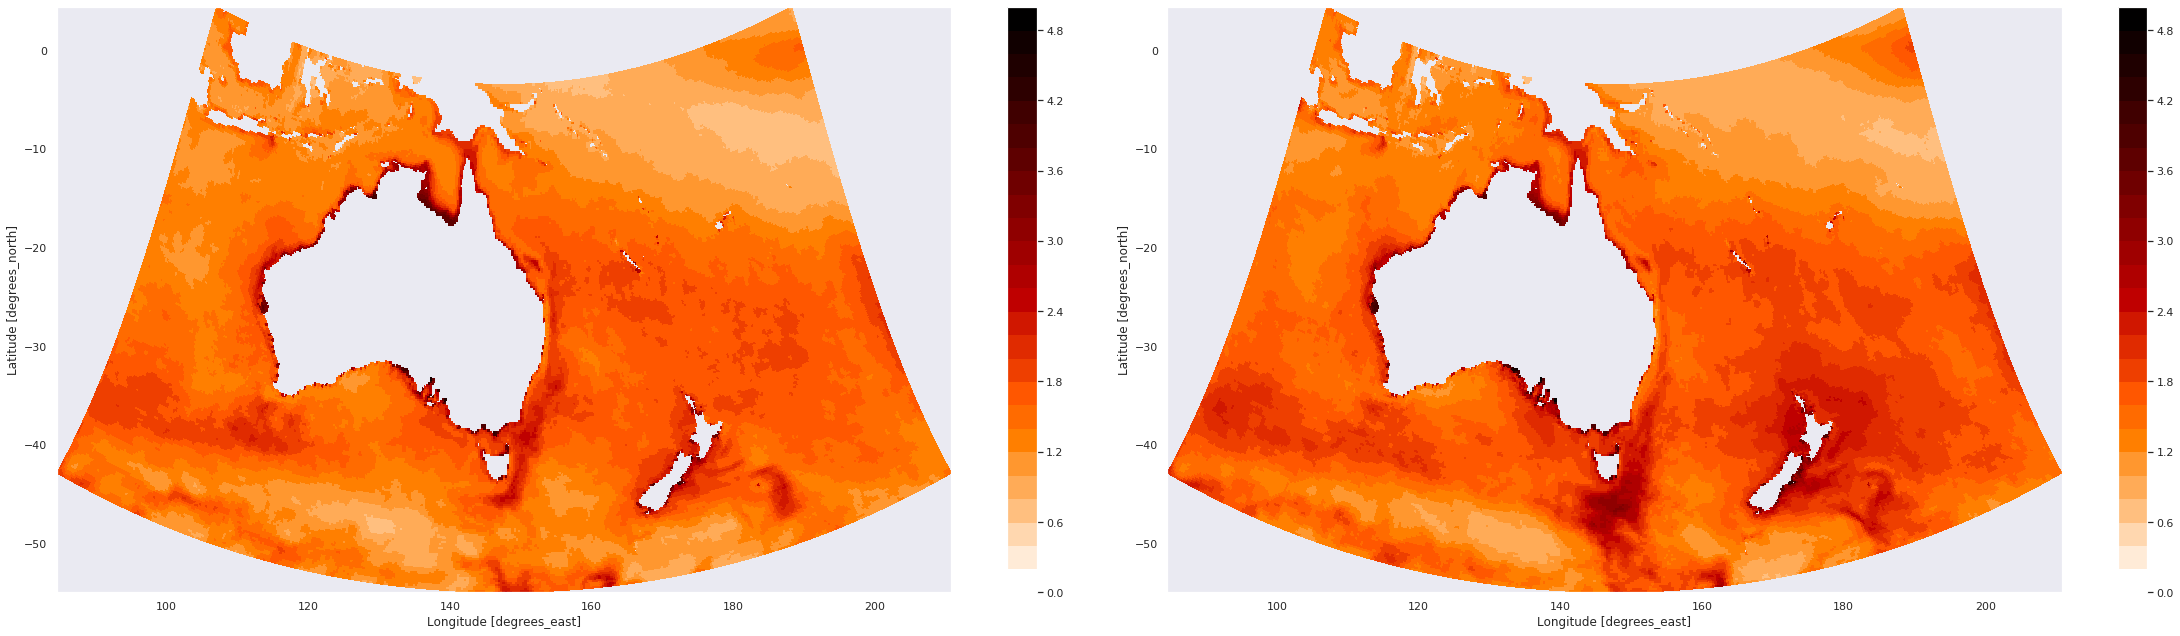

In [147]:
f, axes = plt.subplots(ncols = 2, figsize = [32,9])
vmin, vmax = (0, 5)
levels = linspace(vmin, vmax, (vmax - vmin)*5 + 1)
maxPastSSTA.plot(cmap = cmap_temp, ax = axes[0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, levels = levels);
maxFutSSTA.plot(cmap = cmap_temp, ax = axes[1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, levels = levels);
plt.tight_layout()

### Histogram 

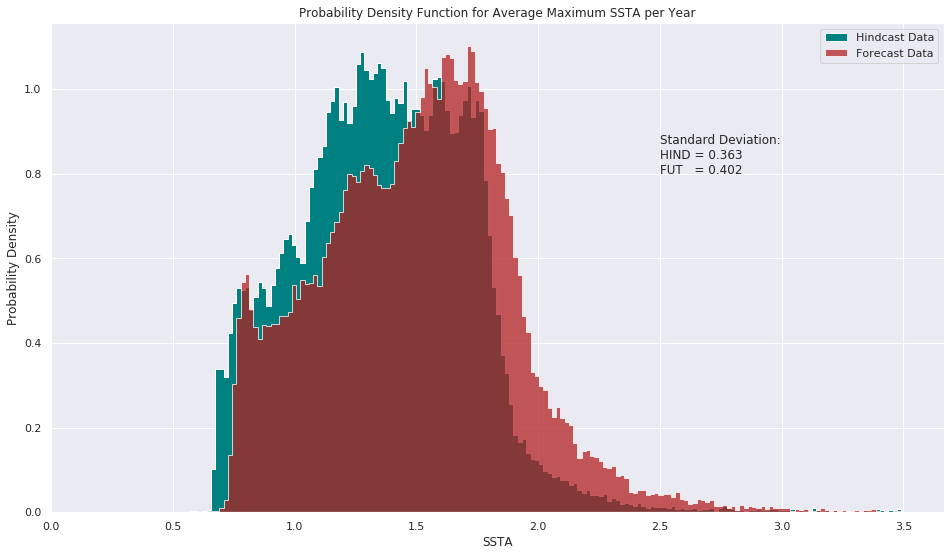

In [169]:
# Plots the frequencies/frequency density for each SSTA. 
bins = np.linspace(0, 3.5, 201)

# True if plotting densities, false if you want just frequency
pltDens = True

(maxPastSSTA * weights).plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Hindcast Data', histtype='stepfilled', color = 'teal')
(maxFutSSTA * weights).plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Forecast Data', histtype='stepfilled', color = 'firebrick', alpha = 0.75);

past_std = maxPastSSTA.std().data
fut_std = maxFutSSTA.std().data
std_str = ('Standard Deviation: \nHIND = {0:.3} \nFUT   = {1:.3}').format(past_std, fut_std)
plt.text(2.5, 0.8, std_str)

plt.ylabel('Probability Density')
plt.xlabel('SSTA')
plt.legend()
plt.xlim(0);
plt.title('Probability Density Function for Average Maximum SSTA per Year');
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/variations/aveMaxSSTAPerYearPDF_semiTrans.png')

### Significance  

In [170]:
SSTA_diff = maxFutSSTA - maxPastSSTA

In [171]:
maxPastSSTA_year = sstaPast.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))
maxFutSSTA_year = sstaFut.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/core/common.py:499: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  restore_coord_dims=restore_coord_dims)


In [172]:
(t, ssta_pValue)  = stats.ttest_rel(maxPastSSTA_year, maxFutSSTA_year)
ssta_sig = np.where(ssta_pValue > 0.05, np.nan, ssta_pValue) 

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x)

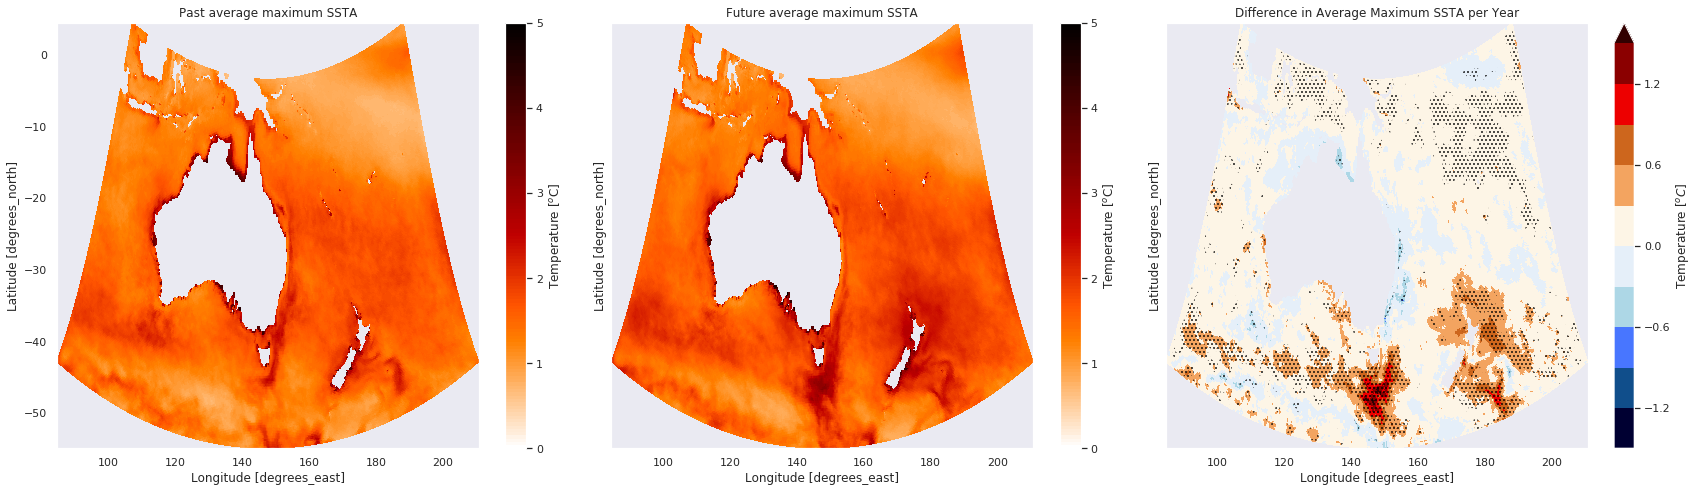

In [194]:
f, axes = plt.subplots(1,3, sharey = True, figsize = [24, 7])
#Past and Future plots
vmin, vmax = (0, 5)
maxPastSSTA.plot(cmap = cmap_temp, ax = axes[0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cbar_kwargs = {'label' : 'Temperature [$^o$C]'});
maxFutSSTA.plot(cmap = cmap_temp,ax = axes[1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cbar_kwargs = {'label' : 'Temperature [$^o$C]'});
axes[0].set_title('Past average maximum SSTA')
axes[1].set_title('Future average maximum SSTA')
# Difference plots
y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
SSTA_diff.plot(cmap = cmap_diff,x = 'nav_lon', y = 'nav_lat', ax = axes[2], cbar_kwargs = {'label' : 'Temperature [$^oC$]'}, vmax = 1.5, levels = linspace(-1.5,1.5,11))
plt.contourf(SSTA_diff['nav_lon'], SSTA_diff['nav_lat'], ssta_sig, levels = [0,0.05], hatches=['...'], colors = 'none');
axes[2].set_title('Difference in Average Maximum SSTA per Year');
plt.tight_layout()
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxDif_all3')

### Seasonal Plots

In [407]:
maxPastSSTA_seas = sstaPast.groupby('time_counter.season').max(dim = 'time_counter').compute()
maxFutSSTA_seas = sstaFut.groupby('time_counter.season').max(dim = 'time_counter').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [466]:
maxSSTA_diff_seas = maxFutSSTA_seas - maxPastSSTA_seas
maxSSTA_diff_seas['nav_lon'] = maxSSTA_diff_seas['nav_lon'] % 360
maxSSTA_diff_seas = maxSSTA_diff_seas.isel(x = slice(5,-5), y = slice(5, -50))
# For some reason groupby gives the following order for the seasons:
seasons = {0:'Summer', 1:'Winter', 2:'Autumn', 3:'Spring'}

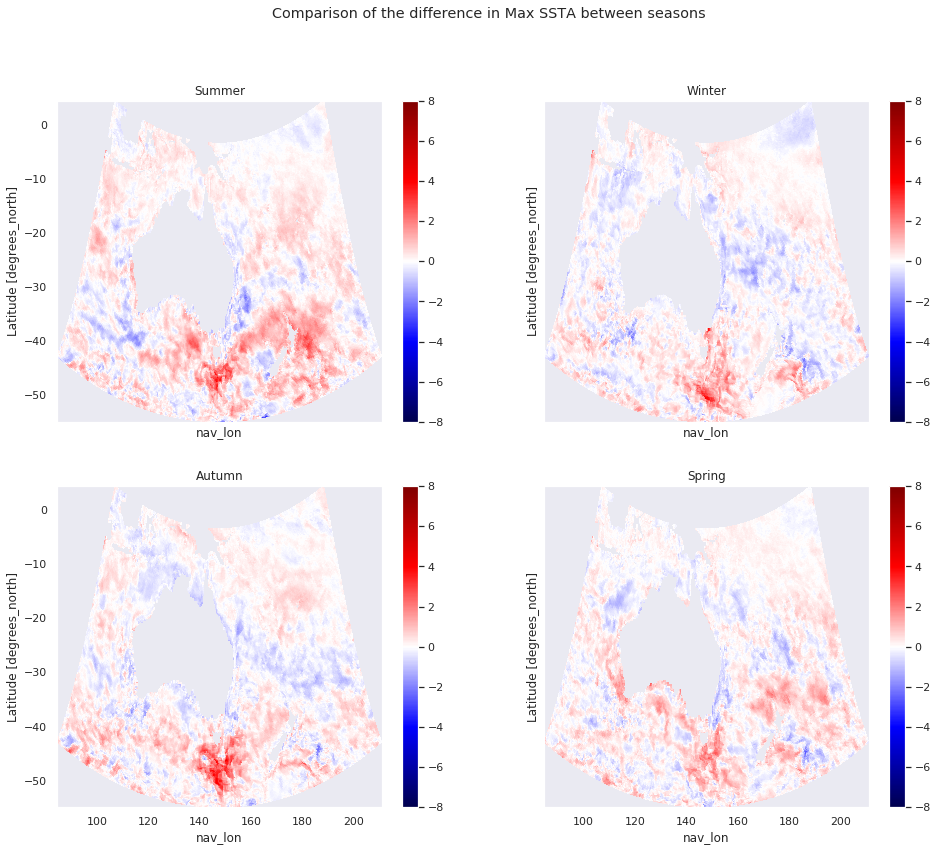

In [483]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Max SSTA between seasons')
vmin, vmax = (-8, 8)
i = 0
for ax in axes.flat:
    maxSSTA_diff_seas[i].plot(cmap = cmap_diff, x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/maxSSTA_seas.png')

## Counting number of MHW days in each simulation

In [79]:
# Assigns a 1 for every mhw day, and sums along time dimension to calculate # of MHW days at each grid point.
pastDays = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 1, 1, 0).sum('time_counter')
#Removes areas where the sum receives 0, i.e. where there are no MHW days ever. This is should be all land.
pastDays = xr.where(pastDays == 0, np.nan, pastDays).compute()

In [80]:
# Same as above
futDays = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 1, 1, 0).sum('time_counter')
futDays = xr.where(futDays == 0, np.nan, futDays).compute()

In [81]:
print(futDays.sum().data/ pastDays.sum().data)
# Increase of 16% in MHW days!

1.1555577554848013


In [82]:
# This changes it from total MHW days to average number of MHW days per year
pastDays = pastDays / 19
futDays = futDays / 19

In [83]:
days_diff = futDays - pastDays

In [84]:
pastDays_year = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 1, 1, 0).groupby('time_counter.year').sum(dim = 'time_counter')
futDays_year = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 1, 1, 0).groupby('time_counter.year').sum(dim = 'time_counter')

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/xarray/core/common.py:499: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  restore_coord_dims=restore_coord_dims)


In [85]:
(t, days_pValue)  = stats.ttest_rel(pastDays_year, futDays_year)

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [86]:
# If you run this, sev_sig stores the:
# significant locations (meaning that the contoured regions of your plot show the significant results)
days_sig = np.where(sev_pValue > 0.05, np.nan, sev_pValue) 
#non-significant locations (meaning that the non contoured regions of your plot show the significant results)
#days_sig = np.where(days_pValue < 0.05, np.nan, days_pValue) 

/g/data1/e14/rm6294/miniconda3/envs/now/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


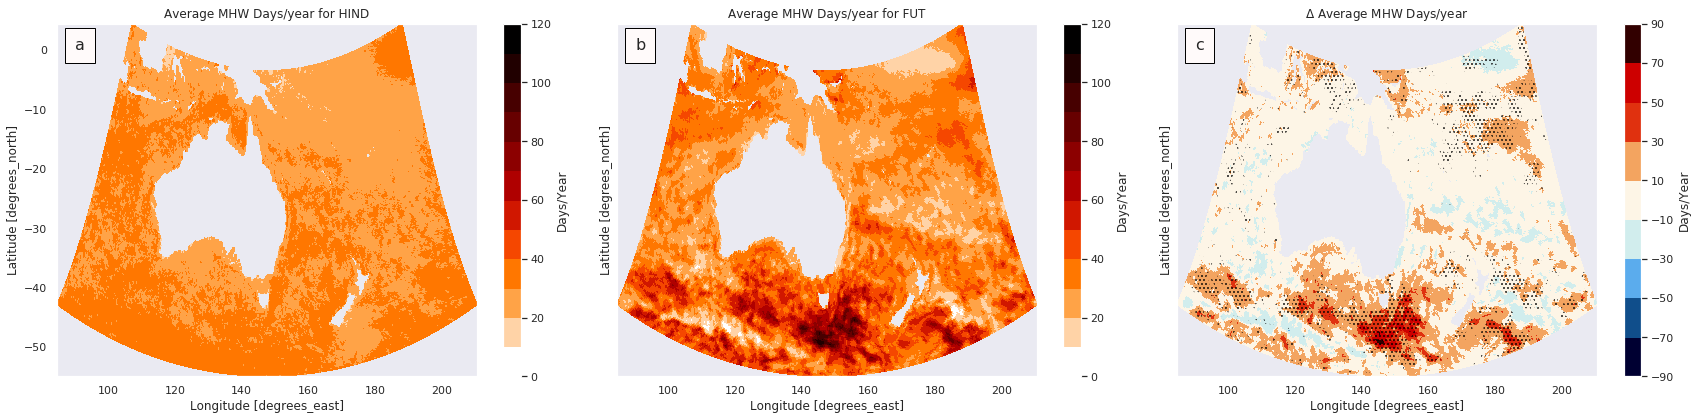

In [88]:
fig, axes = plt.subplots(1, 3, figsize = (24, 6), sharey = True)
vmin, vmax = (0, 120)


pastDays.plot(x = 'nav_lon', y = 'nav_lat', levels = arange(0,130,10), ax = axes[1-1], vmin = vmin, vmax = vmax, cmap = cmap_temp, cbar_kwargs = {'label' : 'Days/Year'});
futDays.plot(x = 'nav_lon', y = 'nav_lat', levels = arange(0,130,10), ax = axes[2-1], vmin = vmin, vmax = vmax, cmap = cmap_temp, cbar_kwargs = {'label' : 'Days/Year'});
days_diff.plot(x = 'nav_lon', y = 'nav_lat', levels = arange(-90,110,20), cmap = cmap_diff, ax = axes[3-1], cbar_kwargs = {'label' : 'Days/Year'});

y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
plt.contourf(days_diff['nav_lon'], days_diff['nav_lat'], days_sig, levels = [0,1], hatches=['...'], colors = 'none');

axes[1-1].set_title('Average MHW Days/year for HIND')
axes[2-1].set_title('Average MHW Days/year for FUT')
axes[3-1].set_title('$\Delta$ Average MHW Days/year')
add_letters(axes)
fig.tight_layout()
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/days_all3_stip.png')

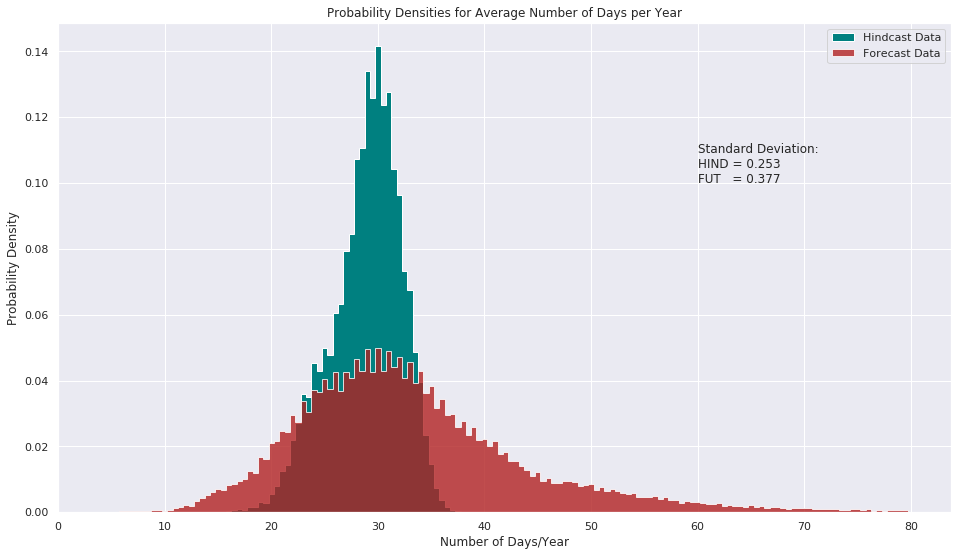

In [165]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,80,161)

# True if plotting densities, false if you want just frequency
pltDens = True

pastDays.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Hindcast Data', histtype='stepfilled', color = 'teal')
futDays.plot.hist(align = 'left',  bins = bins, density = pltDens, label = 'Forecast Data',  histtype='stepfilled', color = 'firebrick', alpha = 0.8);

past_std = np.round(maxPastSev.std().data,3)
fut_std = np.round(maxFutSev.std().data,3)
std_str = ('Standard Deviation:\nHIND = {0}\nFUT   = {1}').format(past_std, fut_std)
plt.text(60, 0.1, std_str)
plt.legend()

plt.ylabel('Probability Density')
plt.xlabel('Number of Days/Year')

plt.title('Probability Densities for Average Number of Days per Year');
plt.xlim(0);
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/variations/aveNumMHWDaysPerYear_semiTrans.png')

In [445]:
pastDays_seas = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).groupby('time_counter.season').sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
pastDays_seas = xr.where(pastDays_seas == 0, np.nan, pastDays_seas).compute()

In [460]:
futDays_seas = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).groupby('time_counter.season').sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
futDays_seas = xr.where(futDays_seas == 0, np.nan, futDays_seas).compute()

In [468]:
daysDiff_seas = futDays_seas - pastDays_seas

# For some reason groupby gives the following order for the seasons:
seasons = {0:'Summer', 1:'Winter', 2:'Autumn', 3:'Spring'}

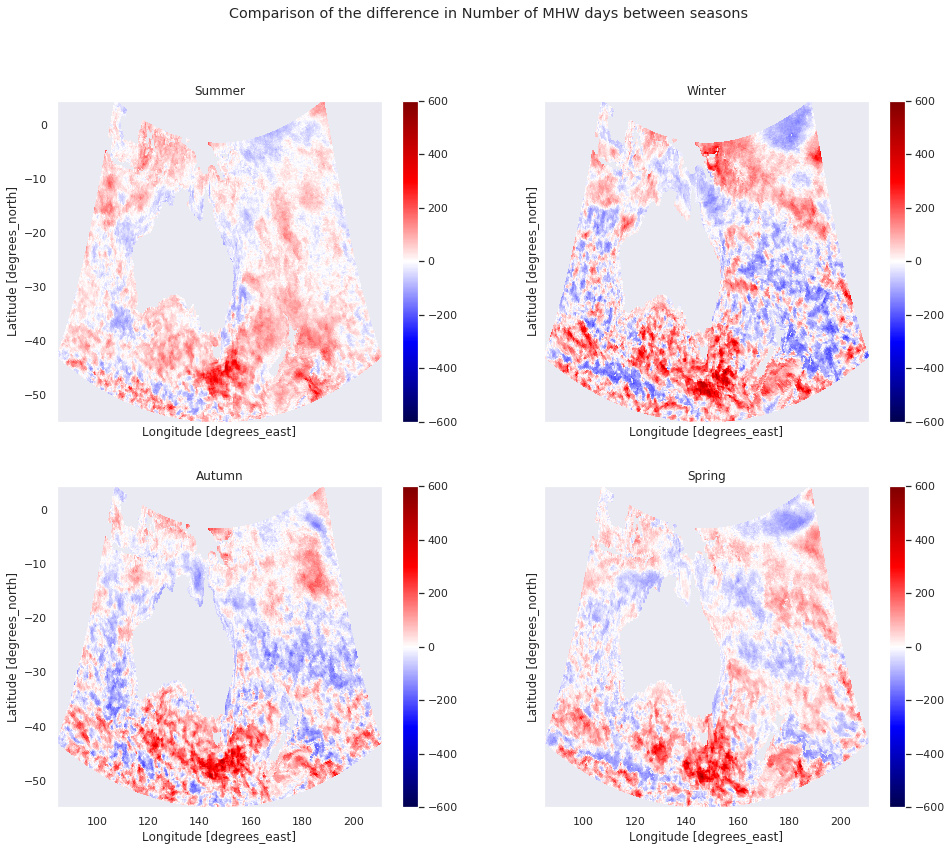

In [477]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Number of MHW days between seasons')
vmin, vmax = (-600, 600)
i = 0
for ax in axes.flat:
    daysDiff_seas[i].plot(cmap = cmap_diff, x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
#plt.savefig('/home/561/rm6294/Documents/maxSSTA_seas.png')

## Severity, SSTA and Days together

In [184]:
 maxFutSSTA - maxPastSSTA

<xarray.DataArray (y: 234, x: 421)>
array([[ 0.416878,  0.27098 ,  0.143543, ..., -0.047248, -0.032128,  0.002299],
       [ 0.406186,  0.24014 ,  0.169718, ..., -0.030034, -0.041623,  0.038863],
       [ 0.382039,  0.166406,  0.131117, ...,  0.06474 ,  0.044577,  0.054775],
       ...,
       [ 0.043734,  0.029285,  0.007889, ...,  0.124283,  0.130389,  0.129526],
       [ 0.047076,  0.020633,  0.018181, ...,  0.082581,  0.098022,  0.108505],
       [ 0.034871,  0.002599,  0.002229, ...,  0.07619 ,  0.094197,  0.128394]],
      dtype=float32)
Coordinates:
    nav_lat  (y, x) float32 -42.806076 -42.903023 ... 4.200698 4.2713823
    nav_lon  (y, x) float32 84.69146 84.92878 85.16658 ... 187.97987 188.16486
Dimensions without coordinates: y, x

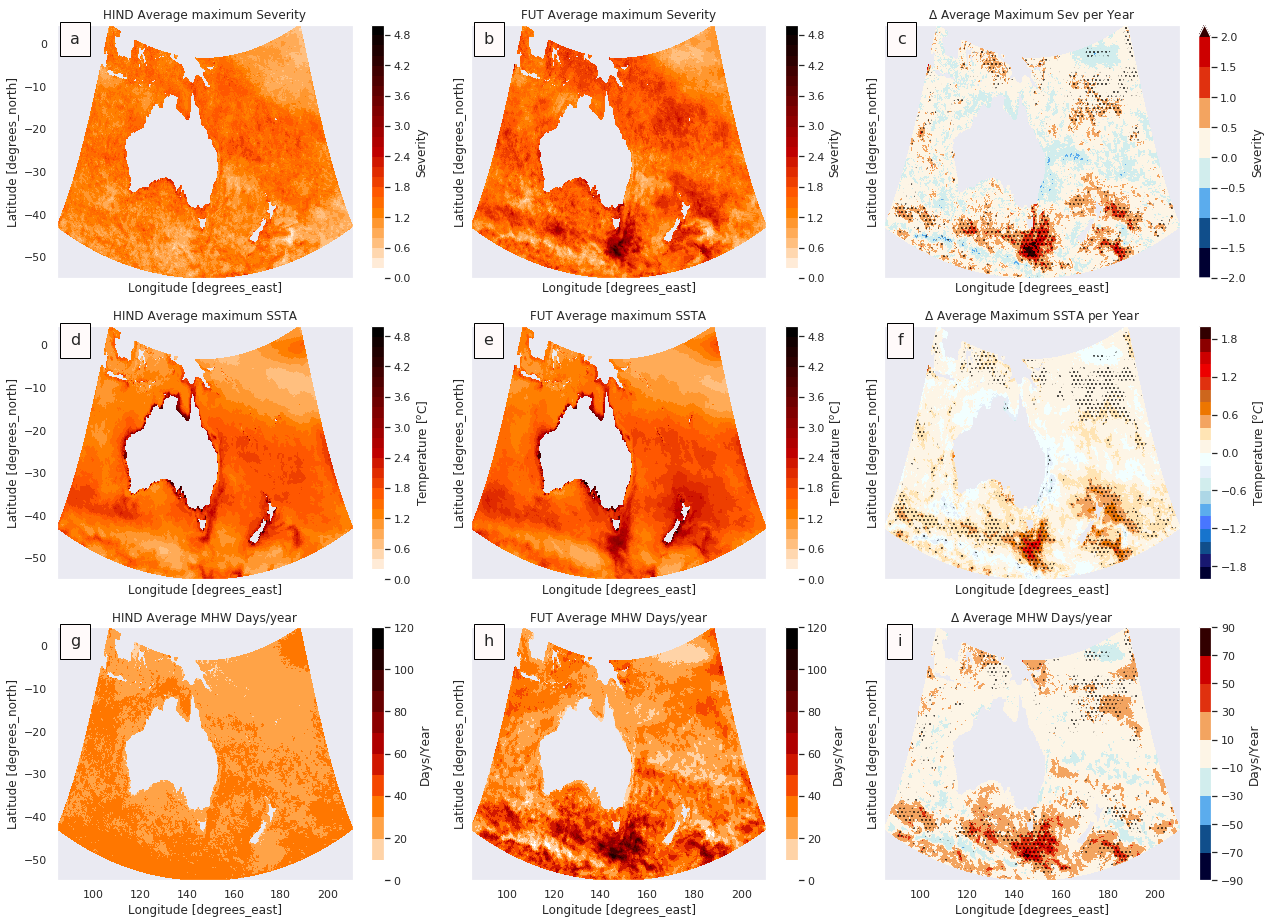

In [209]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, sharex = True, sharey = True, figsize = (18, 13))
hatch_str = '...'
#Severity PLots
vmin, vmax = (0, 5)
maxPastSev.plot(cmap = cmap_temp, ax = axes[0,0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, levels = levels, cbar_kwargs = {'label' : 'Severity'});
maxFutSev.plot(cmap = cmap_temp, ax = axes[0,1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax,  levels = levels, cbar_kwargs = {'label' : 'Severity'});
axes[0,0].set_title('HIND Average maximum Severity')
axes[0,1].set_title('FUT Average maximum Severity')
# Difference and stippling
levels_diff = linspace(-2, 2, 9)
y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
sev_diff.plot(cmap = cmap_diff, x = 'nav_lon', y = 'nav_lat', ax = axes[0,2], levels = levels_diff, cbar_kwargs = {'label' : 'Severity'}, )
axes[0,2].contourf(sev_diff['nav_lon'], sev_diff['nav_lat'], sev_sig, levels = [0,1], hatches=[hatch_str], colors = 'none');
axes[0,2].set_title('$\Delta$ Average Maximum Sev per Year');
# SSTA plots
vmin, vmax = (0, 5)
levels = linspace(vmin, vmax, (vmax - vmin)*5 + 1)
maxPastSSTA.plot(cmap = cmap_temp, ax = axes[1,0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, 
                 levels = levels, cbar_kwargs = {'label' : 'Temperature [$^o$C]'});
maxFutSSTA.plot(cmap = cmap_temp,ax = axes[1,1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax,
                levels = levels, cbar_kwargs = {'label' : 'Temperature [$^o$C]'});

axes[1,0].set_title('HIND Average maximum SSTA')
axes[1,1].set_title('FUT Average maximum SSTA')
# Difference plots
y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
SSTA_diff.plot(cmap = cmap_diff,x = 'nav_lon', y = 'nav_lat', ax = axes[1,2], cbar_kwargs = {'label' : 'Temperature [$^oC$]'}, levels = linspace(-2,2,21))
axes[1,2].contourf(SSTA_diff['nav_lon'], SSTA_diff['nav_lat'], ssta_sig, levels = [0,0.05], hatches=[hatch_str], colors = 'none');
axes[1,2].set_title('$\Delta$ Average Maximum SSTA per Year');

# Num of days plots
(ax1, ax2, ax3) = axes[2]
vmin, vmax = (0, 120)
pastDays.plot(x = 'nav_lon', y = 'nav_lat', levels = arange(0,130,10), ax = ax1, vmin = vmin, vmax = vmax, cmap = cmap_temp, cbar_kwargs = {'label' : 'Days/Year'});
futDays.plot(x = 'nav_lon', y = 'nav_lat', levels = arange(0,130,10), ax = ax2, vmin = vmin, vmax = vmax, cmap = cmap_temp, cbar_kwargs = {'label' : 'Days/Year'});
days_diff.plot(x = 'nav_lon', y = 'nav_lat', levels = arange(-90,110,20), cmap = cmap_diff, ax = ax3, cbar_kwargs = {'label' : 'Days/Year'});
y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
ax3.contourf(days_diff['nav_lon'], days_diff['nav_lat'], days_sig, levels = [0,1], hatches=[hatch_str], colors = 'none');
ax1.set_title('HIND Average MHW Days/year')
ax2.set_title('FUT Average MHW Days/year')
ax3.set_title('$\Delta$ Average MHW Days/year');

add_letters(axes)
plt.tight_layout()
plt.savefig('/home/561/rm6294/Documents/Finished Plots/spatialPlots_3together.png')

# Winds 

In [12]:
# Opens wind speeds and removes troublesome areas
mean_dir = '/g/data1a/e14/gs9353/POST-PROCESS/ECLs/'
u = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_U_2D_mean.nc')['uos'].isel(x = slice(5,-5), y = slice(5,-50))
v = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_V_2D_mean.nc')['vos'].isel(x = slice(5,-5), y = slice(5,-50))

u['nav_lon'] = u['nav_lon'] % 360  
v['nav_lon'] = v['nav_lon'] % 360  

In [13]:
udif = u.sel(simulation = 'Future') - u.sel(simulation = 'Present') 
vdif = v.sel(simulation = 'Future') - v.sel(simulation = 'Present') 

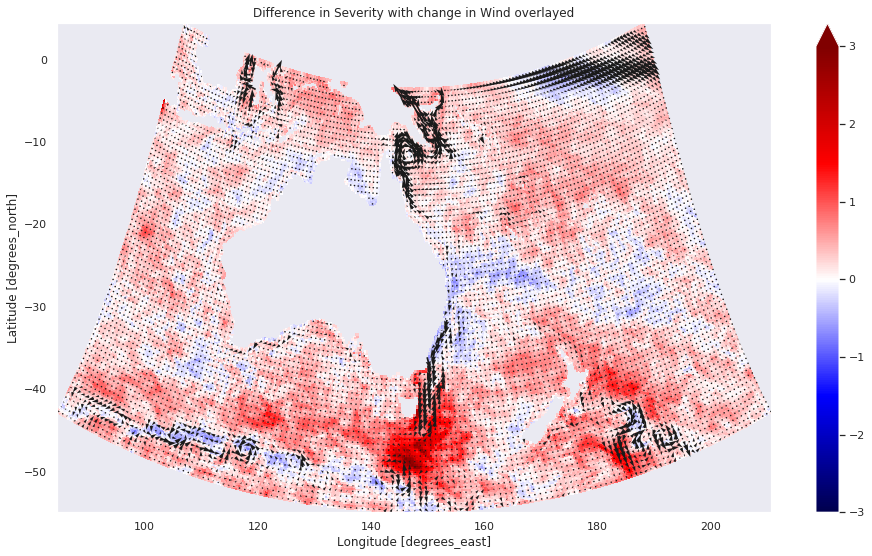

In [18]:
fig, ax = plt.subplots(figsize = (16,9))
sev_diff.plot(x = 'nav_lon', y = 'nav_lat', vmin = -3, vmax = 3, cmap = cmap_diff, ax = ax);
skip = 3
ax.quiver(udif['nav_lon'][::skip, ::skip], vdif['nav_lat'][::skip, ::skip], udif[::skip, ::skip], vdif[::skip, ::skip], pivot='middle', angles='xy', scale_units='xy',  scale = 0.12);
#plt.xlim(140); plt.ylim(-55,-10);
#ax.set_aspect('equal')
plt.title('Difference in Severity with change in Wind overlayed');
plt.savefig('/home/561/rm6294/Documents/Winds/wind_direction_every3.png')

## Trial 

NameError: name 'maxPastSev_trial' is not defined

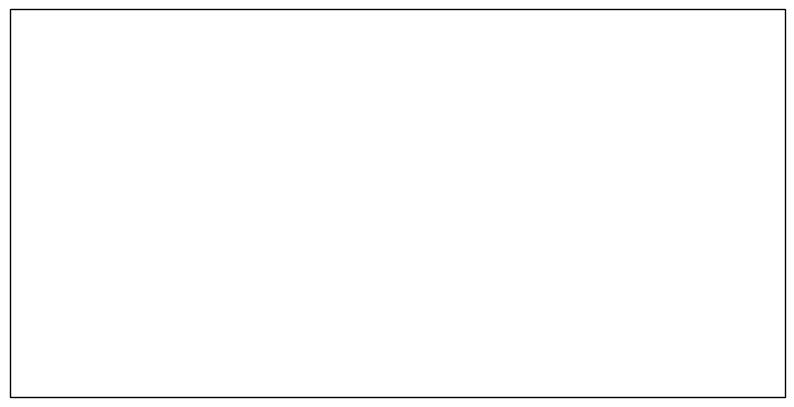

In [318]:
# Trial using cartopy to plot things - too hard to plot over the 180 line, not sure how to get around this problem
central_long =0
projection = ccrs.PlateCarree(central_longitude=central_long)
fig, ax = plt.subplots(figsize =(10,9), subplot_kw={'projection': projection})
vmin = 0; vmax = 5;
maxPastSev_trial['nav_lon'] = maxPastSev['nav_lon'] 
ax = now.plot.add_map(lon_min = 85, lon_max = 180, lat_min = -55, lat_max = 4.5, ax = ax, central_longitude = central_long);
#ax.set_extent([85, 210, -55, 4.5], crs=ccrs.PlateCarree())

maxPastSev_trial.plot(cmap = cmap_temp, ax = ax, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, transform = projection);